In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import interpolate
from scipy import signal
from scipy import fft
from scipy.signal import argrelextrema 
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Plan de proyecto 
<img src="plan.png" alt="da plan">

### 1.- Preprocesamiento (o preparación de los datos)

In [4]:
#Preparación de los datos 
class FrameExtractor:
    
    def __init__(self,path):
        vc = cv2.VideoCapture(path)
        #Obtenemos el número de imágenes del video
        nFrames = 0
        #La frecuencia de muestreo
        fRate = vc.get(cv2.CAP_PROP_FPS)
        self.fRate = fRate
        #Leempos la captura de video
        ret,f = vc.read()
        n = f.shape[0]
        m = f.shape[1]
        #Creamos el stack de imágenes
        self.frameStack = []
        self.n = n
        self.m = m
        i = 0
        #Vamos a extraer todos los frames y se almacenaran en una pila de imagenes 
        #frame stack
        while(True):
            ret,f = vc.read()
            if(ret):
                self.frameStack.append(cv2.cvtColor(f, cv2.COLOR_BGR2GRAY))
                nFrames += 1
            else:
                break
        self.nFrames = nFrames
        vc.release()
        
    #Obtiene el frame especificado en index
    def getImg(self,index):
        if(index > self.nFrames-1):
            print("Index is out of bounds")
        else:
            return self.frameStack[index]
        
    #Obtiene el stack de imágenes
    def getImgStack(self):
        return self.frameStack
    
    #Getters para las dimensiones de la imagen
    def getHeight(self):
        return self.n
    
    def getWidth(self):
        return self.m
    
    def getFrameRate(self):
        return self.fRate
    
    def getNumberOfFrames(self):
        return self.nFrames
    
    def getDeltaT(self):
        return 1/self.fRate
    
    def getTArray(self,initialFrame):
        duration = (self.getNumberOfFrames()-initialFrame-1)*self.getDeltaT()
        tArr = np.arange(0,duration,self.getDeltaT())
        n = np.size(tArr,0)
        if(np.abs(tArr[n-1]- duration) == 0):
            return tArr[0:n-1]
        else:
            return tArr

In [5]:
#Voy a seguir una metoddología parecida a la que se plantea el articulo, donde se detectan características
# y se hace el tracking de las mismas usando flujo óptico 

class FeatureTracker:
    
    def __init__(self, frameExtractor):
        self.frameExtractor = frameExtractor
    
    #Detect features 
    def detectFeatures(self,initialIndex):
        self.initialIndex = initialIndex
        initialImage = self.frameExtractor.getImg(initialIndex).copy()
        #Vamos a usar los valores que vienen en los ejemplos de open cv
        qualityLevel = 0.01
        maxCorners = 30
        minDistance = 20
        
        self.features = cv2.goodFeaturesToTrack(initialImage, maxCorners, qualityLevel, minDistance)
        self.numberOfFeatures = len(self.features)
        for i in self.features:
            x,y = i.ravel()
            cv2.circle(initialImage,(x,y),10,255,-1)
        self.featuresImage = initialImage
            
    
    def plotFeaturesToTrack(self):
        plt.figure()
        plt.title("Características a seguir")
        #Mostramos la imagen 
        plt.imshow(self.featuresImage,cmap = "gray")
        #Mostramos los puntos
        
    #Suponiendo que ya tenemos las características ahora debemos usar Lukas Kanade
    
    
    def lukasKanadeTrack(self):
        oldPic = self.frameExtractor.getImg(self.initialIndex)
        trajectories = np.zeros((self.frameExtractor.getNumberOfFrames()-self.initialIndex-1,2,self.numberOfFeatures))
        previousPoints = self.features
        for i in range(self.initialIndex+1,self.frameExtractor.getNumberOfFrames()):
            nextImage = self.frameExtractor.getImg(i)
            nextFeatures, stat, err = cv2.calcOpticalFlowPyrLK(oldPic, nextImage, previousPoints,None)
            #Almacenamos las nuevas posiciones de las características. 
            for j in range(0,len(nextFeatures)):
                feature = nextFeatures[j]
                x,y = feature.ravel()
                trajectories[i-self.initialIndex-1,0,j] = x
                trajectories[i-self.initialIndex-1,1,j] = y
                
            previousPoints = nextFeatures
            oldPic = nextImage
        self.trajectories = trajectories
    #Graficamos el track de la i-ésima característica. aquí lo que queremos realmente es graficar
    #una animación del track
    def plotTrack(self,trackIndex,seconds):
        self.fig, self.ax = plt.subplots()
        self.plotTrackIndex = trackIndex
        #Convertimos a milisegundas el delta de tiempo entre cuadro y cuadro
        deltaT = self.frameExtractor.getDeltaT()*(10 **3)
        
        numFrames = int(np.floor(seconds/self.frameExtractor.getDeltaT()))
        fr = range(self.initialIndex,self.initialIndex + numFrames-1)
        anim = FuncAnimation(self.fig, self.plotDot, frames = fr, interval = deltaT, blit = False)
        return HTML(anim.to_html5_video())
    
    def plotDot(self, i):
        
        vector = self.trajectories[i,:,self.plotTrackIndex]
        self.ax.clear()
        self.ax.set_title("Seguimiento de la característica "+str(self.plotTrackIndex))
        self.ax.imshow(self.frameExtractor.getImg(i),cmap = "gray")
        self.ax.plot(vector[0],vector[1],marker = 'o',markersize = 10, color = 'red')
        
    #Aquí se va a verificar cuales de las caracteristicas tienen valores que no cambien de un momento a otro
    #y las vamos a eliminar
    def cleanFeatures(self):
        valid = []
        for i in range(0,self.getNumberOfFeatures()):
            x = self.trajectories[:,0,i]
            y = self.trajectories[:,1,i]
            
            isValid = True
            step = 1
            for j in range(0,len(x)-2):
                if(x[j] == x[j+step] and y[j] == y[j+step]):
                    isValid = False
            
            if(isValid):
                valid.append(i)
            else:
                print("cleaned "+str(i))
        
        self.numberOfFeatures = len(valid)
        newTrajectories = np.zeros((np.size(self.trajectories, 0), 2, self.numberOfFeatures))
        for i in range(0,self.getNumberOfFeatures()):
            
            x = self.trajectories[:,0,valid[i]]
            y = self.trajectories[:,1,valid[i]]
            newTrajectories[:,0,i] = x
            newTrajectories[:,1,i] = y
        
        self.trajectories = newTrajectories
            
        
    
    #Hecho esto tenemos que hacer un resampleo, ya que un ECG generalmente va a estar
    #captando a una frecuencia de muestreo de 250 Hz, mientras que nuestra cámara lo hace
    #a una frecuencia de 30 Hz. En el articulo lo que mencionan es que habría que usar
    #algo que se llama interpolación bicubica de splines o algo asi 
    def resampleMotion(self,freq):
        self.newSamplingFrequency = freq
        #El tiempo total que estamos abarcando
        totalTime = self.frameExtractor.getDeltaT()*(self.frameExtractor.getNumberOfFrames() - self.initialIndex)
        #El número de grames que tendriamos en la nueva frecuencia
        newDeltaT = 1/freq
        numFramesInNewFrequency = int(np.floor(totalTime/newDeltaT))
        newSamples = np.linspace(0,totalTime,numFramesInNewFrequency)
        self.newTArray = newSamples
        #Bien, ahora que tenemos el nuevo sampling vamos a empezar a iterar
        resampledTrajectories = np.zeros((numFramesInNewFrequency,2,self.getNumberOfFeatures()))
        for i in range(0,self.getNumberOfFeatures()):
            x = self.trajectories[:,0,i]
            y = self.trajectories[:,1,i]
            tArr = self.frameExtractor.getTArray(self.initialIndex)
            #El parametro s es smoothing
            tck, u = interpolate.splprep([x,y], s = 0, u = tArr)
            #Resampleo
            out = interpolate.splev(newSamples, tck)
            resampledTrajectories[:,0,i] = out[0]
            resampledTrajectories[:,1,i] = out[1]
        self.resampledTrajectories = resampledTrajectories
        
    
    def resampleMotionUsingSVR(self, freq):
        #Los parametros para la regresion
        eps  = 0.2
        regConstant = 1.0
        totalTime = self.frameExtractor.getDeltaT()*(self.frameExtractor.getNumberOfFrames() - self.initialIndex)
        newDeltaT = 1/freq
        numFramesInNewFrequency = int(np.floor(totalTime/newDeltaT))
        newSamples = np.linspace(0, totalTime, numFramesInNewFrequency)
        self.newSamplingFrequency = freq
        self.newTArray = newSamples
        #Ahora si iteramos recordemos que lo que hay que ajustar son las funciones x(t) y(t)
        resampledTrajectories = np.zeros((numFramesInNewFrequency, 2, self.getNumberOfFeatures()))
        oldTArr = self.frameExtractor.getTArray(self.initialIndex)
        for i in range(0, self.getNumberOfFeatures()):
            x = self.trajectories[:,0,i]
            y = self.trajectories[:,1, i]
            #Ajustamos x(t)
            regrX = make_pipeline(StandardScaler(), SVR(C = regConstant, epsilon = eps, kernel = 'rbf'))
            regrX.fit(oldTArr.reshape(-1,1), x)
            newX = regrX.predict(newSamples.reshape(-1,1))
            
            #Ajustamos y(t)
            regrY = make_pipeline(StandardScaler(), SVR(C = regConstant, epsilon = eps, kernel = 'rbf'))
            regrY.fit(oldTArr.reshape(-1, 1), y)
            newY = regrY.predict(newSamples.reshape(-1,1))
            
            #Guardamos 
            resampledTrajectories[:,0,i] = newX
            resampledTrajectories[:,1,i] = newY
        
        #Una vez hecho lo anterior entonces guardamos las trayectorias resampleads en nuestro objeto. 
        self.resampledTrajectories = resampledTrajectories

    #Compares the resampled trajectory of a specified feature with the un resampled one
    def plotResampledTrajectory(self, index):
        prevTArray = self.frameExtractor.getTArray(self.initialIndex)
        newTArray = self.newTArray
        oldFreq = self.frameExtractor.getFrameRate()
        newFreq = self.newSamplingFrequency
        xOld = self.trajectories[:,0,index]
        yOld = self.trajectories[:,1,index]
        xNew = self.resampledTrajectories[:,0,index]
        yNew = self.resampledTrajectories[:,1,index]
        
        plt.figure()
        fig, ax = plt.subplots(2,2,figsize=(10, 10))
        ax[0,0].plot(prevTArray, xOld,'o')
        ax[0,0].set_title('x(t) Frecuencia de muestreo: 30 '+" Hz")
        ax[0,0].set_xlabel("Tiempo (s)")
        ax[0,0].set_ylabel("x(t)")
        ax[0,1].plot(prevTArray, yOld,'o')
        ax[0,1].set_title('y(t) Frequencia de muestreo: 30'+" Hz")
        ax[0,1].set_xlabel("Tiempo (s)")
        ax[0,1].set_ylabel("y(t)")
        ax[1,0].plot(newTArray, xNew,'o')
        ax[1,0].set_title('x(t) Frecuencia de muestreo '+str(newFreq) + " Hz")
        ax[1,0].set_xlabel("Tiempo (s)")
        ax[1,0].set_ylabel("x(t)")
        ax[1,1].plot(newTArray,yNew,'o')
        ax[1,1].set_title('y(t) Frecuencia de muestreo '+str(newFreq) + " Hz")
        ax[1,1].set_xlabel("Tiempo (s)")
        ax[1,1].set_ylabel("y(t)")
    
    def getNumberOfFeatures(self):
        return self.numberOfFeatures
    
            
            
    

### 2.- Procesamiento de los datos

In [6]:
#Procesamiento 
class HRExtractor:
    
    #Para inicializar debemos darle las series de tiempo de las 
    #características y el arreglo de tiempo de las mismas
    def __init__(self, tracker):
        self.tracker = tracker
        self.timeSeries = tracker.resampledTrajectories
        self.timeArray = tracker.newTArray
        #Algo importante es que la frecuencia de muestreo debe ser 30Hz
        self.Fs = tracker.newSamplingFrequency
        #Frecuencias alta y baja para filtrar
        #Estas se encuentran en Hz
        #self.lowFreq = 0.75
        #self.highFreq = 2
        self.lowFreq = 0.75
        self.highFreq = 20
    
    def filterTimeSeries(self):
        #Construimos el filtro butterworth
        nyquist = 0.5*self.Fs
        low = self.lowFreq / nyquist
        high = self.highFreq / nyquist
        #El filtro será de orden 5
        order = 5
        b, a = signal.butter(order, [low, high], btype='band')
        #Vamos a filtrar las series de tiempo
        n = np.size(self.timeSeries, 0)
        featureNumber = np.size(self.timeSeries,2)
        filteredTimeSeries = np.zeros((n,2,featureNumber))
        
        for i in range(0,featureNumber):
            x = self.timeSeries[:,0,i]
            y = self.timeSeries[:,1,i]
            filteredX = signal.lfilter(b,a,x)
            filteredY = signal.lfilter(b,a,y)
            #Almacenamos las series de tiempo filtradas
            filteredTimeSeries[:,0,i] = filteredX
            filteredTimeSeries[:,1,i] = filteredY
        self.filteredTimeSeries = filteredTimeSeries
            
    #Aquí no se bien como nombrar a este método pero basicamente lo que quiero 
    #Es graficar para una caracteristica dada los espectros 
    def plotFilteredDataSpectra(self, feature):
        filteredX = self.filteredTimeSeries[:,0,feature]
        filteredY = self.filteredTimeSeries[:,1,feature]
        
        #Obtenemos el espectro de Fourier
        n = np.size(self.timeArray,0)
        samples = int(self.Fs*(self.timeArray[n-1]-self.timeArray[0])) 
        frequencyInterval =  fft.rfftfreq(samples, 1 / self.Fs)
        xFourier = np.abs(fft.rfft(filteredX))
        yFourier = np.abs(fft.rfft(filteredY))
        
        plt.figure()
        fig, ax = plt.subplots(2,2,figsize=(10, 10))
        #x(t)
        ax[0,0].set_title("x(t) de característica "+str(feature))
        ax[0,0].plot(self.timeArray,filteredX)
        ax[0,0].set_xlabel("Tiempo [s]")
        ax[0,0].set_ylabel("x(t)")
        #y(t)
        ax[0,1].set_title("y(t) de característica "+str(feature))
        ax[0,1].plot(self.timeArray,filteredY)
        ax[0,1].set_xlabel("Tiempo [s]")
        ax[0,1].set_ylabel("y(t)")
        #X(w)
        ax[1,0].set_title("Espectro X(f) de característica "+str(feature))
        ax[1,0].plot(frequencyInterval, xFourier)
        ax[1,0].set_xlabel("Frecuencia [Hz]")
        ax[1,0].set_ylabel("|X(f)|")
        ax[1,0].set_xlim([self.lowFreq,self.highFreq])
        #Y(w)
        ax[1,1].set_title("Espectro Y(f) de característica "+str(feature))
        ax[1,1].plot(frequencyInterval,yFourier)
        ax[1,1].set_xlabel("Frecuencia [Hz]")
        ax[1,1].set_ylabel("|Y(f)|")
        ax[1,1].set_xlim([self.lowFreq,self.highFreq])
    
    def getPrincipalComponents(self):
        #Obtenemos la media del movimiento en las componentes x y y
        numOfFeatures = self.tracker.getNumberOfFeatures()
        xMean = np.zeros(numOfFeatures)
        yMean = np.zeros(numOfFeatures)
        T = np.size(self.timeArray,0)
        
        for i in range(0,T):
            xMean = xMean + (1/T)*self.filteredTimeSeries[i,0,:]
            yMean = yMean + (1/T)*self.filteredTimeSeries[i,1,:]
        
        #Obtenemos las matrices de covarianza de x y ye (sospecho que van a estar muy gigantes)
        T = np.size(self.timeArray,0)
        xCovarianceMatrix = np.zeros((numOfFeatures,numOfFeatures))
        yCovarianceMatrix = np.zeros((numOfFeatures,numOfFeatures))
        
        print(np.size(self.timeSeries,2))
        for i in range(0, T):
            xCovarianceMatrix = xCovarianceMatrix + (1/T) *np.tensordot((self.filteredTimeSeries[i,0,:] - xMean),(self.filteredTimeSeries[i,0,:] - xMean),axes = 0)
            yCovarianceMatrix = yCovarianceMatrix + (1/T)*np.tensordot((self.filteredTimeSeries[i,1,:] - yMean),(self.filteredTimeSeries[i,1,:] - yMean),axes = 0)
        
        #Obtenemos los eigenvectores
        valuesX, vectorsX = np.linalg.eig(xCovarianceMatrix)
        valuesY, vectorsY = np.linalg.eig(xCovarianceMatrix)
        
        projectedTimeSeries = np.zeros((T,2,numOfFeatures))
        print(np.size(vectorsX,0))
        #Segun la documentación de python los eigenvectores ya deben estar normalizados asi que podemos hacer directamente la proyección 
        for i in range(0,np.size(vectorsX,0)):
            vectorX = vectorsX[:,i]
            vectorY = vectorsY[:,i]
            #Proyectamos para obtener las componentes principales
            projectedTimeSeries[:,0,i] = np.dot(self.filteredTimeSeries[:,0,:],vectorX)
            projectedTimeSeries[:,1,i] = np.dot(self.filteredTimeSeries[:,1,:],vectorY)
        
        self.projectedTimeSeries = projectedTimeSeries
    
    #Ploteamos la serie de tiempo que se nos indique
    def plotProjectedTimeSeries(self, i):
        fig, ax = plt.subplots(1,2,figsize=(15, 5))
        
        ax[0].set_title("x(t) de la componente principal "+str(i))
        ax[0].plot(self.timeArray, self.projectedTimeSeries[:,0,i])
        ax[0].set_xlabel("Tiempo [s]")
        ax[0].set_ylabel("x(t)")
        ax[1].set_title("y(t) de la componente principal "+str(i))
        ax[1].plot(self.timeArray, self.projectedTimeSeries[:,1,i])
        ax[1].set_xlabel("Tiempo [s]")
        ax[1].set_ylabel("y(t)")
    
    #Seleccionamos por periodicidad a las componentes candidatas
    def selectComponentCandidates(self):
        n = np.size(self.timeArray,0)
        samples = int(self.Fs*(self.timeArray[n-1]-self.timeArray[0]))
        frequencyInterval =  fft.rfftfreq(samples, 1 / self.Fs)
        T = np.size(self.timeArray,0)
        fourierSpectraX = np.zeros((int(T/2)+1,self.tracker.getNumberOfFeatures()))
        fourierSpectraY = np.zeros((int(T/2)+1,self.tracker.getNumberOfFeatures()))
        
        periodicityX = np.zeros(self.tracker.getNumberOfFeatures())
        periodicityY = np.zeros(self.tracker.getNumberOfFeatures())
        
        for i in range(0,self.tracker.getNumberOfFeatures()):
            xSpectra = np.abs(fft.rfft(self.projectedTimeSeries[:,0,i]))
            ySpectra = np.abs(fft.rfft(self.projectedTimeSeries[:,1,i]))
            
            #Guardamos los espectros
            fourierSpectraX[:,i] = xSpectra
            fourierSpectraY[:,i] = ySpectra
            
            periodicityX[i] = self.computePeriodicity(xSpectra)
            periodicityY[i] = self.computePeriodicity(ySpectra)
            
            
        #Ordenamos por periodicidad
        indicesX = np.linspace(0,self.tracker.getNumberOfFeatures()-1,self.tracker.getNumberOfFeatures())
        indicesY = np.linspace(0,self.tracker.getNumberOfFeatures()-1, self.tracker.getNumberOfFeatures())
        indicesX = [x for _,x in sorted(zip(periodicityX,indicesX))]
        indicesY = [x for _,x in sorted(zip(periodicityY,indicesY))]
        
        #Ya que ordenamos ahora hacemos nuestro arreglo de 5 soluciones mas periodicas.
        #Solutions 
        
        solutionsByPeriodicity = np.zeros((T, len(indicesX) + len(indicesY)))
        ix = 0
        iy = 0
        for i in range(0, len(indicesX) + len(indicesY)):
            if(periodicityX[int(indicesX[ix])] >= periodicityY[int(indicesY[iy])]):
                solutionsByPeriodicity[:,i] = self.projectedTimeSeries[:,0,int(indicesX[ix])]
                ix += 1
                if(ix >= len(indicesX)):
                    ix = len(indicesX)-1
            else:
                solutionsByPeriodicity[:,i] = self.projectedTimeSeries[:,1,int(indicesY[iy])]
                iy += 1
                if(iy >= len(indicesY)):
                    iy = len(indicesY) - 1
        
        
        self.selectedComponents = solutionsByPeriodicity[:,0:5]
        
    def computePeriodicity(self,spectra):
        peaks = []
        sumSpectra = sum(spectra)
        for i in range(1,len(spectra)-1):
            der1 = spectra[i] - spectra[i-1]
            der2 = spectra[i+1]-spectra[i]
            
            if((der1 > 0 and der2 < 0) or (der1 <0 and der2 > 0)):
                peaks.append(spectra[i])
        return sum(peaks)/sumSpectra
    
    def plotSelectedComponent(self,i):
        plt.figure()
        plt.title("Grafico de la componente seleccionada "+str(i))
        plt.plot(self.timeArray, self.selectedComponents[:,i])
        plt.xlabel("Tiempo [s]")
        plt.ylabel("y(t)")
    
    def getHR(self):
        maxLim = 130
        minLim = 45
        #Sacamos el espectro de la componente mas grande
        biggerComponent = self.selectedComponents[:, 0]
        n = np.size(self.timeArray,0)
        samples = int(self.Fs*(self.timeArray[n-1]-self.timeArray[0]))
        frequencyInterval =  fft.rfftfreq(samples, 1 / self.Fs)
        T = np.size(self.timeArray,0)
        fourierSpectra =  np.abs(fft.rfft(biggerComponent))
        max_ind = argrelextrema(fourierSpectra, np.greater)
        maxFreq = frequencyInterval[max_ind]  
        
        hrCandidates = []
        for i in range(0,len(maxFreq)):
            freq = maxFreq[i]*60
            if(freq <maxLim and freq >minLim):
                hrCandidates.append(freq)
        self.hrComponentSpectra = fourierSpectra
        self.frequencyInterval = frequencyInterval
        self.maxIndexes = max_ind
        hrCandidates.sort(key = self.sortByPeakHeight)
        return hrCandidates[::-1]
    
    def sortByPeakHeight(self, candidate):
        index = np.where(self.frequencyInterval==candidate/60)
        return self.hrComponentSpectra[index]
        
            
    
    
    def plotHRComponentSpectra(self,s):
        plt.figure()
        plt.title(s)
        plt.plot(self.frequencyInterval*60, self.hrComponentSpectra)
        plt.xlabel("Frecuencia [bpm]")
        plt.ylabel("amplitud")
        plt.xlim([0,300])

### 3.- Validación del código

Para corroborar que el código esté funcionando de forma adecuada se grabó el video de un péndulo, esto como referencia. El péndulo que se grabó tiene una extensión de 35 cm de modo que la frecuencia esperada es 


\begin{equation}
f = \frac{1}{2\pi} \sqrt{\frac{g}{l}} = 0.80Hz
\end{equation} 

que en bpm sería 48.2


In [7]:
l = 38.5
lMeters = l*10**-2
g = 9.81
pi = 3.1416
freq = (1/(2*pi))* np.sqrt(g/lMeters)
freqBPM = freq*60
print(freq)
print(freqBPM)

0.8033841421260286
48.20304852756172


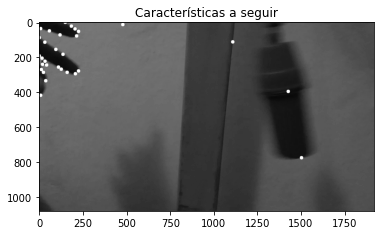

In [8]:
#Abrimos el video
videoFrames = FrameExtractor("pendulo_2.mp4")
#hacemos el tracking de caracteristicas
tracker = FeatureTracker(videoFrames)
tracker.detectFeatures(1)
tracker.plotFeaturesToTrack()

In [9]:
#Hacemos el tracking y limpiamos las características que no presentan movimiento, i.e. todas las de la pared. 
tracker.lukasKanadeTrack()
tracker.cleanFeatures()

cleaned 0
cleaned 1
cleaned 2
cleaned 3
cleaned 4
cleaned 6
cleaned 7
cleaned 8
cleaned 9
cleaned 10
cleaned 11
cleaned 12
cleaned 13
cleaned 15
cleaned 16
cleaned 17
cleaned 18
cleaned 19
cleaned 20
cleaned 21
cleaned 22
cleaned 23
cleaned 24
cleaned 25
cleaned 26
cleaned 27
cleaned 28
cleaned 29


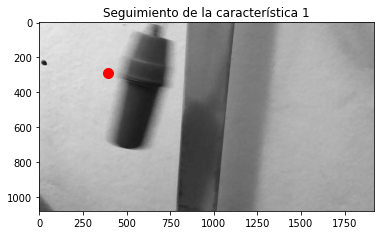

In [10]:
#Ahora examinemos una de las trayectorias
secondsToTrack = 3
featureToTrack = 1
tracker.plotTrack(featureToTrack,secondsToTrack)

In [11]:
#Probemos el resampleo
newSamplingFrequency = 250
tracker.resampleMotion(newSamplingFrequency)

<Figure size 432x288 with 0 Axes>

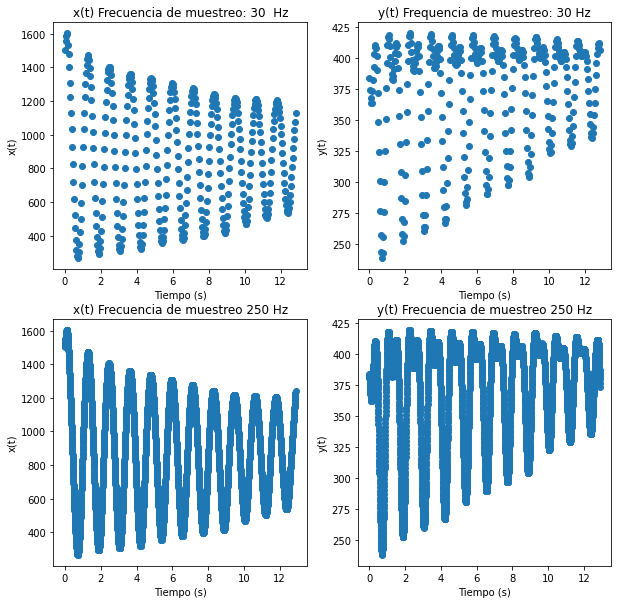

In [12]:
#Grafico del resampleo
tracker.plotResampledTrajectory(1)

<Figure size 432x288 with 0 Axes>

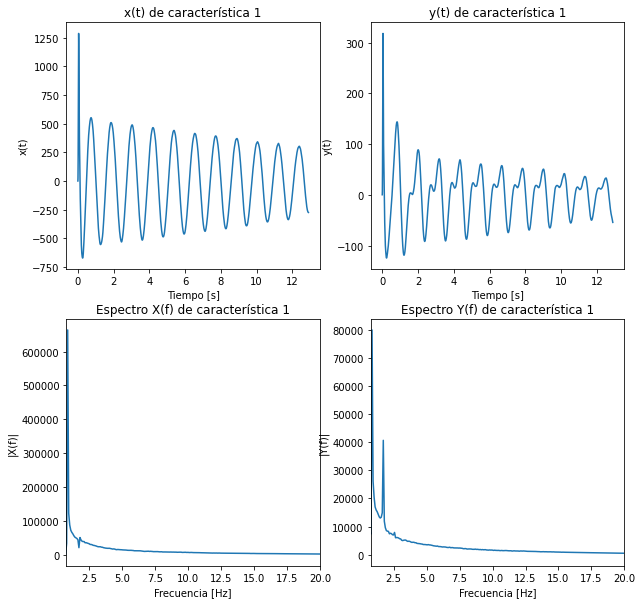

In [13]:
#Creamos el extractor de frecuencia cardiaca
hrExtractor = HRExtractor(tracker)
#Vamos a filtrar las series de tiempo
hrExtractor.filterTimeSeries()
#Graficamos las series de tiempo filtradas
hrExtractor.plotFilteredDataSpectra(1)

2
2


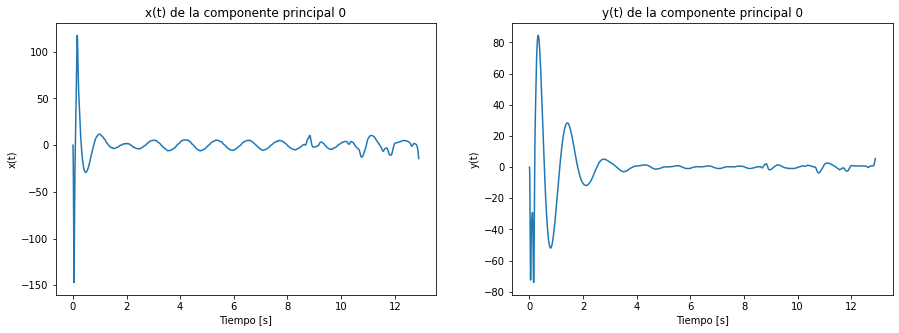

In [14]:
#Extracción de componentes principales
hrExtractor.getPrincipalComponents()
hrExtractor.plotProjectedTimeSeries(0)

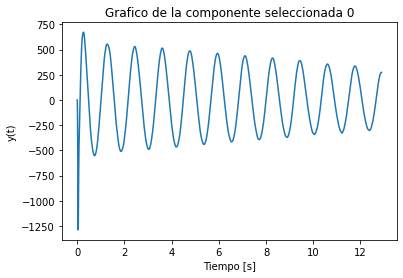

In [15]:
#Selección de componente mas periodica
hrExtractor.selectComponentCandidates()
hrExtractor.plotSelectedComponent(0)

In [16]:
#Obtención de la frecuencia cardiaca
hrCandidates = hrExtractor.getHR()

for i in range(0, len(hrCandidates)):
    print(str(hrCandidates[i]) + " bpm") 

51.194539249146764 bpm
107.04312752094324 bpm
125.65932361154205 bpm


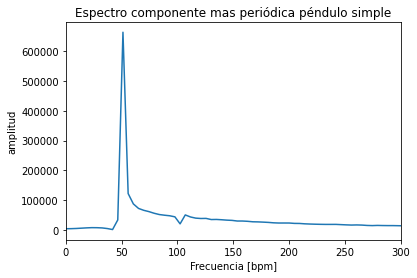

In [17]:
hrExtractor.plotHRComponentSpectra("Espectro componente mas periódica péndulo simple")

### 3.- Experimento de muestra
Al medir mi frecuencia cardiaca justo antes de hacer el experimento era de <b>73bpm</b> (Se que necesito mejor forma de comparar pero no tengo las herramientas necesarias aquí). 

Aquí por la forma en que diseñe el experimento debo considerar también la frecuencia de péndulo del llavero, este media 9 cm así que esperariamos un pico espurio en 100 bpm. 

<img src = "final_arrangement.jpg" width = "250" height = "250"/>

<img src = "pendulum.gif" width = "200" height = "200"/>

Para ángulos pequeños este sistema se comporta en forma lineal, esto implica que su movimiento imita la forma que tenga la perturbación entrante.

<img src = "bpm.jpg" width = "250" height = "250"/>

In [350]:
l = 9
lMeters = l*10**-2
g = 9.81
pi = 3.1416
freq = (1/(2*pi))* np.sqrt(g/lMeters)
freqBPM = freq*60
print(freq)
print(freqBPM)

1.6616225026913916
99.6973501614835


In [351]:
videoFrames = FrameExtractor("Experimentos/sample_video.mp4")

cleaned 1
cleaned 8
cleaned 12
cleaned 17
cleaned 25


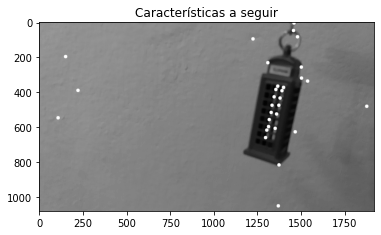

In [352]:
#hacemos el tracking de caracteristicas
tracker = FeatureTracker(videoFrames)
tracker.detectFeatures(4)
tracker.plotFeaturesToTrack()
tracker.lukasKanadeTrack()
tracker.cleanFeatures()

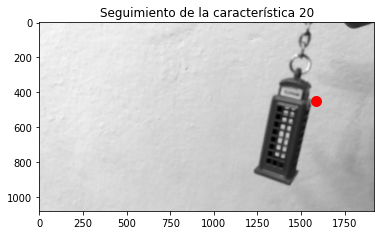

In [353]:
secondsToTrack = 1
featureToTrack = 20
tracker.plotTrack(featureToTrack,secondsToTrack)

<Figure size 432x288 with 0 Axes>

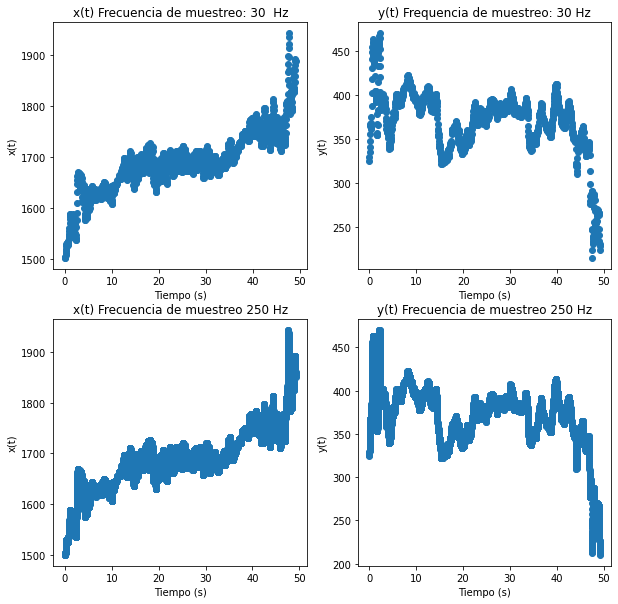

In [354]:
#Probemos el resampleo
newSamplingFrequency = 250
tracker.resampleMotion(newSamplingFrequency)
tracker.plotResampledTrajectory(20)

<Figure size 432x288 with 0 Axes>

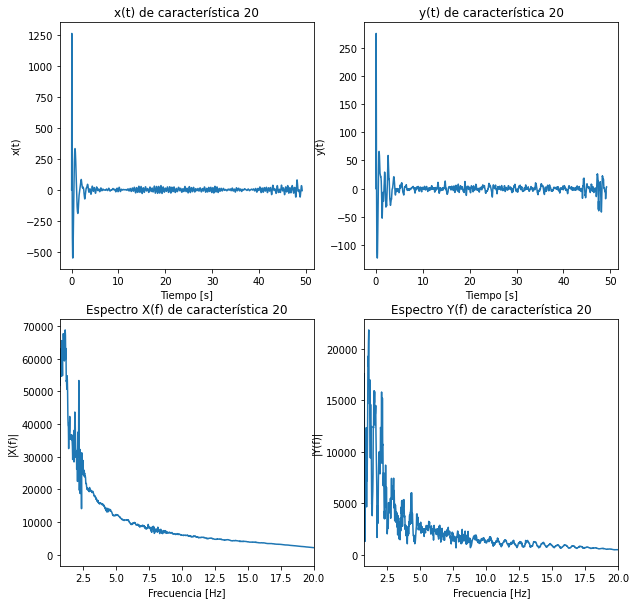

In [355]:
#Creamos el extractor de frecuencia cardiaca
hrExtractor = HRExtractor(tracker)
#Vamos a filtrar las series de tiempo
hrExtractor.filterTimeSeries()
#Graficamos las series de tiempo filtradas
hrExtractor.plotFilteredDataSpectra(20)

25
25


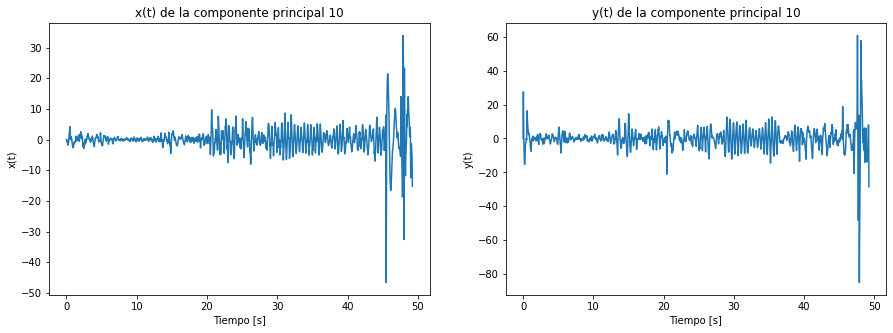

In [356]:
#Extracción de componentes principales
hrExtractor.getPrincipalComponents()
hrExtractor.plotProjectedTimeSeries(10)

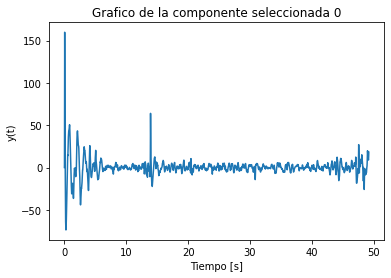

In [357]:
#Selección de componente mas periodica
hrExtractor.selectComponentCandidates()
hrExtractor.plotSelectedComponent(0)

In [358]:
#Obtención de la frecuencia cardiaca
hrCandidates = hrExtractor.getHR()

for i in range(0, len(hrCandidates)):
    print(str(hrCandidates[i]) + " bpm") 

91.441111923921 bpm
47.54937820043891 bpm
51.207022677395756 bpm
56.083881980004875 bpm
73.1528895391368 bpm
81.68739331870276 bpm
68.27603023652767 bpm
59.741526456961715 bpm
79.2489636673982 bpm
129.23677151914166 bpm
104.85247500609607 bpm
102.41404535479151 bpm
115.82540843696658 bpm
108.5101194830529 bpm
86.56425262131188 bpm
110.94854913435746 bpm
119.48305291392343 bpm
123.14069739088028 bpm
99.97561570348695 bpm
125.57912704218482 bpm
95.09875640087782 bpm


C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:220: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


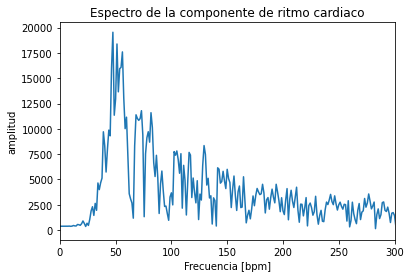

In [359]:
#El primer pico correspondería a movimientoss involuntarios de la mano, cuya frecuencia según la literatura 
#va entre 10Hz, 60Hz
hrExtractor.plotHRComponentSpectra()

### Otro ejemplo de ahorita
<img src = "bpm_2.jpg" width = "250" height = "250"/>

In [360]:
videoFrames = FrameExtractor("Experimentos/sample_2.mp4")

cleaned 0
cleaned 3
cleaned 17
cleaned 24


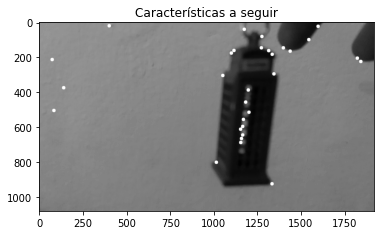

In [361]:
#hacemos el tracking de caracteristicas
tracker = FeatureTracker(videoFrames)
tracker.detectFeatures(4)
tracker.plotFeaturesToTrack()
tracker.lukasKanadeTrack()
tracker.cleanFeatures()

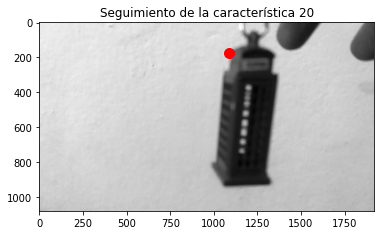

In [362]:
secondsToTrack = 1
featureToTrack = 20
tracker.plotTrack(featureToTrack,secondsToTrack)

<Figure size 432x288 with 0 Axes>

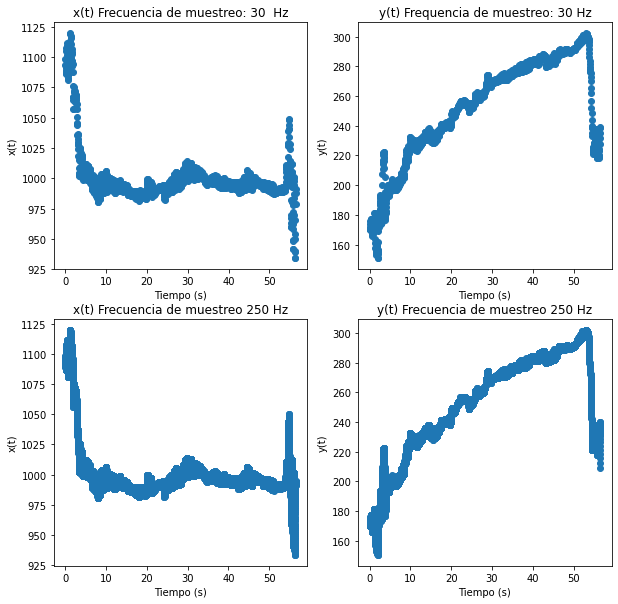

In [363]:
newSamplingFrequency = 250
tracker.resampleMotion(newSamplingFrequency)
tracker.plotResampledTrajectory(20)

<Figure size 432x288 with 0 Axes>

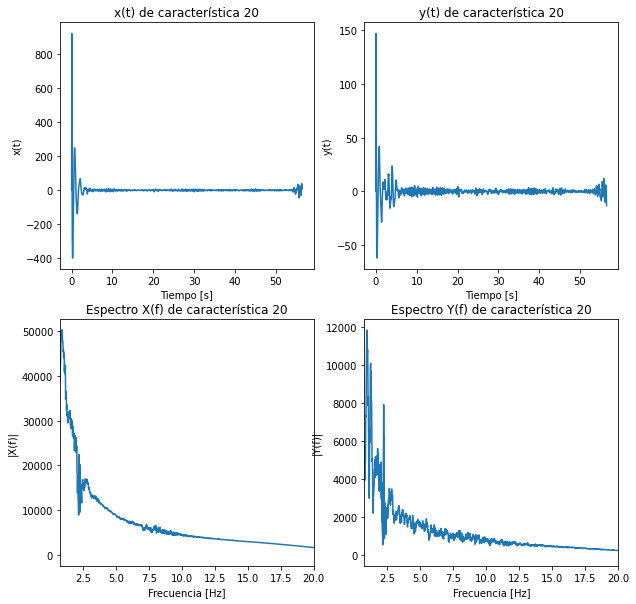

In [364]:
#Creamos el extractor de frecuencia cardiaca
hrExtractor = HRExtractor(tracker)
#Vamos a filtrar las series de tiempo
hrExtractor.filterTimeSeries()
#Graficamos las series de tiempo filtradas
hrExtractor.plotFilteredDataSpectra(20)

26
26


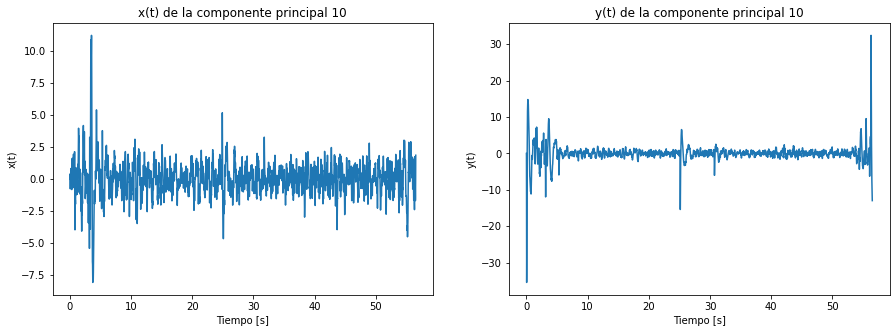

In [365]:
#Extracción de componentes principales
hrExtractor.getPrincipalComponents()
hrExtractor.plotProjectedTimeSeries(10)

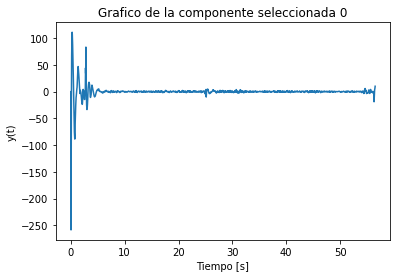

In [366]:
#Selección de componente mas periodica
hrExtractor.selectComponentCandidates()
hrExtractor.plotSelectedComponent(0)

In [367]:
#Obtención de la frecuencia cardiaca
hrCandidates = hrExtractor.getHR()

for i in range(0, len(hrCandidates)):
    print(str(hrCandidates[i]) + " bpm") 

49.907971117089055 bpm
47.78422766529803 bpm
55.21732974656662 bpm
57.34107319835764 bpm
78.57850771626788 bpm
76.45476426447685 bpm
59.46481665014866 bpm
45.66048421350701 bpm
98.75407050828261 bpm
61.58856010193969 bpm
100.87781396007362 bpm
64.77417527962622 bpm
66.89791873141725 bpm
69.02166218320828 bpm
117.86776157440183 bpm
127.42460710746143 bpm


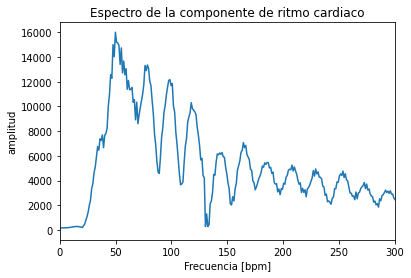

In [368]:
hrExtractor.plotHRComponentSpectra()

## 4.-Comparación usando SVR para interpolar

Se me ocurrió para el segundo de los puntos del parcial que tenia que ver con SVM, que podía en vez de usar splines probar hacer un ajuste usando la SVM de regresión y a partir de dicho ajuste predecir cual debe ser el valor de los puntos restantes a interpolar. 

cleaned 7
cleaned 14
cleaned 18
cleaned 27


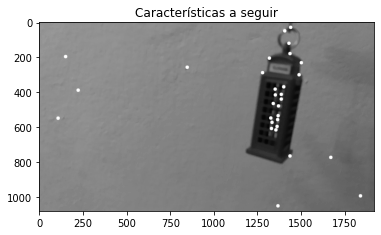

In [321]:
videoFrames = FrameExtractor("Experimentos/sample_video.mp4")
#hacemos el tracking de caracteristicas
tracker = FeatureTracker(videoFrames)
tracker.detectFeatures(1)
tracker.plotFeaturesToTrack()
tracker.lukasKanadeTrack()
tracker.cleanFeatures()

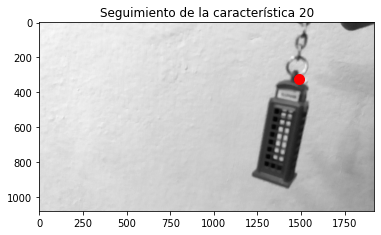

In [322]:
secondsToTrack = 1
featureToTrack = 20
tracker.plotTrack(featureToTrack,secondsToTrack)

<Figure size 432x288 with 0 Axes>

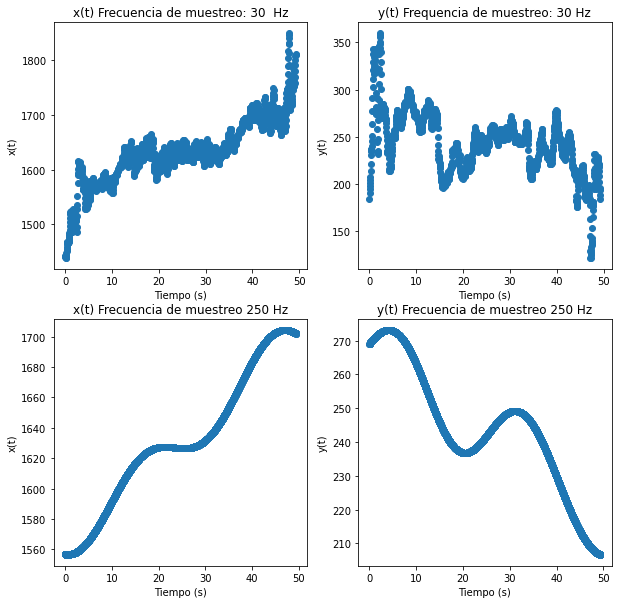

In [323]:
#Probemos el resampleo usando una SVR 
newSamplingFrequency = 250
tracker.resampleMotionUsingSVR(newSamplingFrequency)
tracker.plotResampledTrajectory(20)

<Figure size 432x288 with 0 Axes>

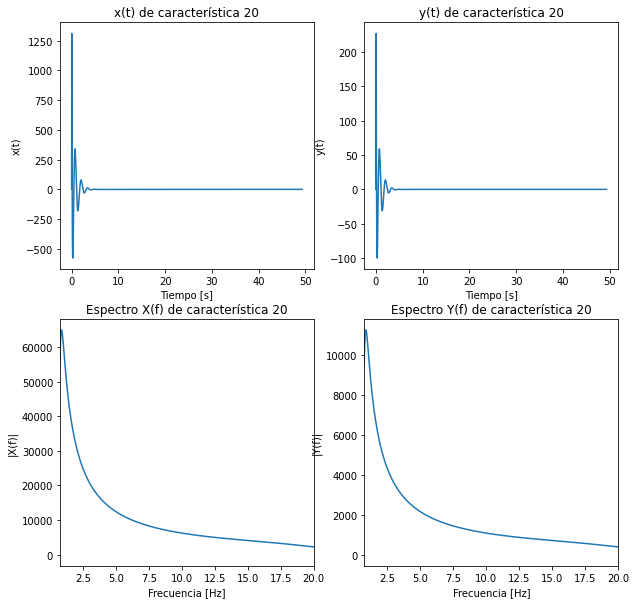

In [324]:
#Creamos el extractor de frecuencia cardiaca
hrExtractor = HRExtractor(tracker)
#Vamos a filtrar las series de tiempo
hrExtractor.filterTimeSeries()
#Graficamos las series de tiempo filtradas
hrExtractor.plotFilteredDataSpectra(20)

26
26


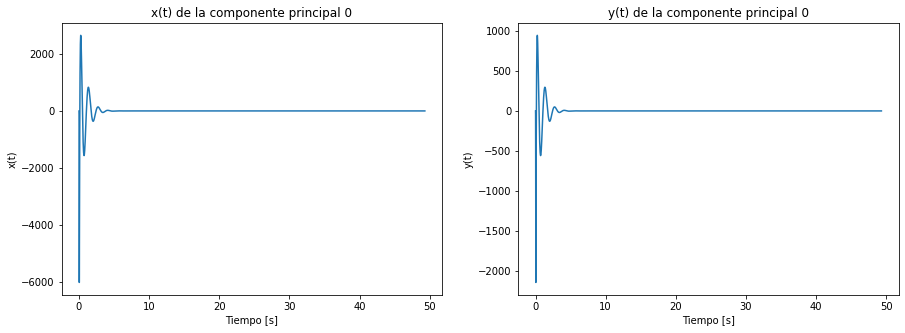

In [325]:
hrExtractor.getPrincipalComponents()
hrExtractor.plotProjectedTimeSeries(0)

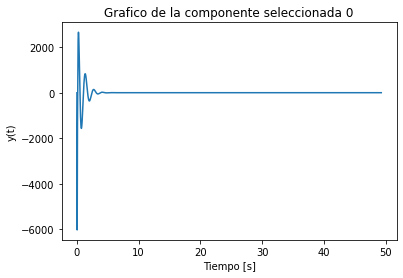

In [326]:
hrExtractor.selectComponentCandidates()
hrExtractor.plotSelectedComponent(0)

In [327]:
#Obtención de la frecuencia cardiaca
hrCandidates = hrExtractor.getHR()

for i in range(0, len(hrCandidates)):
    print(str(hrCandidates[i]) + " bpm") 

51.10317975340688 bpm


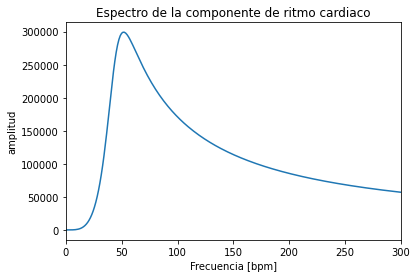

In [328]:
hrExtractor.plotHRComponentSpectra()

## 6.- Error relativo

cleaned 12
cleaned 18
cleaned 23
cleaned 24
cleaned 25
cleaned 26
24
24


C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:220: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


126.88821752265859 bpm
107.4665515753129 bpm
64.73888649115236 bpm
59.55977557186016 bpm
45.31722054380664 bpm
49.20155373327578 bpm
75.09710832973673 bpm
68.62321968062149 bpm
124.29866206301251 bpm
62.14933103150626 bpm
121.70910660336641 bpm
54.38066465256797 bpm
82.865774708675 bpm
78.98144151920586 bpm
93.22399654725938 bpm
104.8769961156668 bpm
97.10832973672852 bpm
102.2874406560207 bpm
85.4553301683211 bpm
111.35088476478204 bpm
115.23521795425118 bpm
71.21277514026758 bpm
119.11955114372032 bpm
90.63444108761328 bpm
cleaned 4
cleaned 8
cleaned 9
cleaned 12
cleaned 13
cleaned 14
cleaned 16
cleaned 17
cleaned 19
cleaned 20
cleaned 21
cleaned 22
cleaned 24
cleaned 25
cleaned 26
cleaned 27
cleaned 28
13
13


C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:220: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


99.75172902996985 bpm
46.550806880652594 bpm
57.19099131051605 bpm
49.210852988118454 bpm
118.37205178223088 bpm
53.20092214931725 bpm
83.79145238517467 bpm
79.80138322397588 bpm
61.18106047171483 bpm
103.74179819116864 bpm
93.10161376130519 bpm
77.14133711651002 bpm
122.36212094342966 bpm
126.35219010462846 bpm
63.8411065791807 bpm
87.78152154637345 bpm
69.16119879411242 bpm
111.72193651356623 bpm
114.3819826210321 bpm
cleaned 1
cleaned 4
cleaned 8
cleaned 10
cleaned 11
cleaned 14
cleaned 15
cleaned 17
cleaned 18
cleaned 19
cleaned 20
cleaned 21
cleaned 22
cleaned 23
cleaned 24
cleaned 25
cleaned 27
cleaned 29
12
12


C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:220: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


116.45962732919256 bpm
101.38838143953234 bpm
64.39532334673 bpm
80.83668249908659 bpm
57.54475703324808 bpm
72.6160029229083 bpm
87.6872488125685 bpm
94.53781512605042 bpm
126.05042016806723 bpm
108.23894775301424 bpm
50.69419071976617 bpm
cleaned 1
cleaned 7
cleaned 8
cleaned 14
cleaned 16
cleaned 17
cleaned 19
cleaned 23
cleaned 28
21
21


C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:220: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


129.06309751434034 bpm
87.34573266122024 bpm
53.45037371806014 bpm
63.879714931340175 bpm
79.52372675126021 bpm
119.93742395272032 bpm
75.6127237962802 bpm
114.7227533460803 bpm
95.16773857118025 bpm
66.48705023466017 bpm
123.84842690770034 bpm
105.59707978446029 bpm
cleaned 0
cleaned 1
cleaned 2
cleaned 3
cleaned 4
cleaned 5
cleaned 6
cleaned 7
cleaned 8
cleaned 9
cleaned 11
cleaned 12
cleaned 13
cleaned 14
cleaned 15
cleaned 16
cleaned 17
cleaned 18
cleaned 19
cleaned 20
cleaned 21
cleaned 22
cleaned 23
cleaned 24
cleaned 25
cleaned 26
cleaned 27
cleaned 28
cleaned 29
1
1
93.8408670367433 bpm
64.7634152788792 bpm
67.40681998413957 bpm
60.79830822098863 bpm
89.87575997885276 bpm
56.83320116309807 bpm
48.902987047316934 bpm
117.6315093840867 bpm
52.868094105207504 bpm
79.30214115781126 bpm
87.23235527359239 bpm
105.73618821041501 bpm
101.77108115252443 bpm
96.48427174200368 bpm
126.883425852498 bpm
71.37192704203014 bpm
111.02299762093575 bpm
83.26724821570183 bpm
124.24002114723763 bp

C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:220: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


cleaned 0
cleaned 1
cleaned 2
cleaned 3
cleaned 4
cleaned 5
cleaned 6
cleaned 7
cleaned 8
cleaned 9
cleaned 10
cleaned 11
cleaned 12
cleaned 13
cleaned 14
cleaned 16
cleaned 17
cleaned 19
cleaned 20
cleaned 21
cleaned 22
cleaned 23
cleaned 24
cleaned 25
cleaned 26
cleaned 27
cleaned 28
3
3
90.46412026920723 bpm
55.0651166856044 bpm
66.86478454680535 bpm
58.998339306004716 bpm
74.73122978760598 bpm
77.35337820120618 bpm
62.931561926405024 bpm
69.48693296040555 bpm
48.50974565160387 bpm
79.9755266148064 bpm
83.90874923520671 bpm
94.39734288960754 bpm
87.84197185560703 bpm
107.50808495760859 bpm
102.26378813040817 bpm
119.30775281880953 bpm
115.37453019840922 bpm
111.4413075780089 bpm
98.33056551000786 bpm


C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:220: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


cleaned 3
cleaned 4
cleaned 8
cleaned 12
cleaned 14
cleaned 15
cleaned 16
cleaned 17
cleaned 19
cleaned 20
cleaned 21
cleaned 24
cleaned 25
cleaned 27
cleaned 28
cleaned 29
14
14
123.52032938754503 bpm
48.89346371590324 bpm
92.64024704065878 bpm
82.34688625836336 bpm
114.51363870303653 bpm
56.613484302624805 bpm
72.05352547606793 bpm
117.0869788986104 bpm
97.78692743180648 bpm
61.760164693772516 bpm
108.0802882141019 bpm
cleaned 0
cleaned 2
cleaned 3
cleaned 5
cleaned 7
cleaned 8
cleaned 9
cleaned 10
cleaned 11
cleaned 16
cleaned 19
cleaned 24
cleaned 26
cleaned 28
cleaned 29
15
15
128.58149365899482 bpm
119.77454203851573 bpm
112.72898074213245 bpm
52.84170972287458 bpm
95.11507750117426 bpm
100.39924847346172 bpm
72.2170032879286 bpm
68.69422263973696 bpm
86.30812588069516 bpm
cleaned 0
cleaned 3
cleaned 4
cleaned 6
cleaned 8
cleaned 10
cleaned 11
cleaned 12
cleaned 14
cleaned 15
cleaned 17
cleaned 19
cleaned 21
cleaned 22
cleaned 24
cleaned 26
cleaned 27
13
13
119.45845500398194 bpm

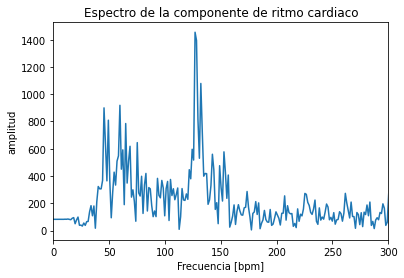

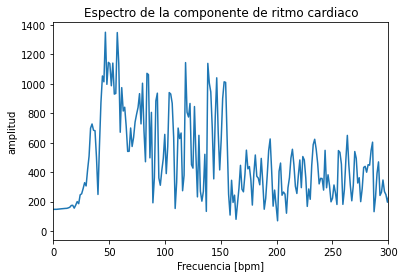

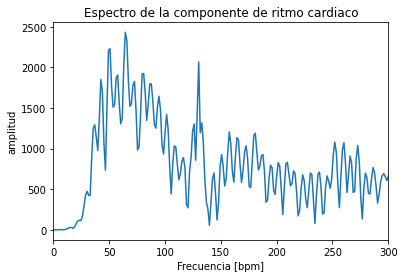

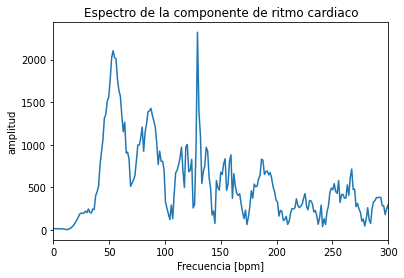

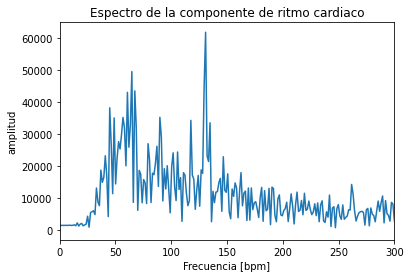

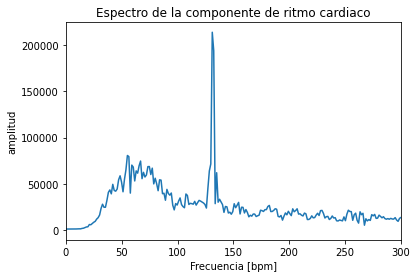

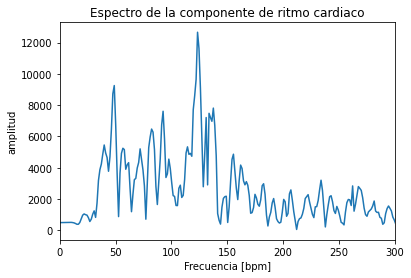

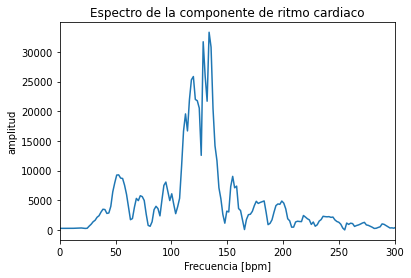

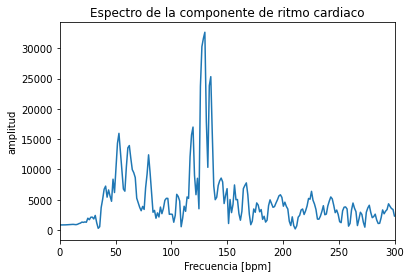

In [16]:
paths = ["rel_err/1.mp4","rel_err/2.mp4","rel_err/3.mp4","rel_err/4.mp4","rel_err/5.mp4","rel_err/6.mp4","rel_err/7.mp4","rel_err/8.mp4","rel_err/9.mp4"]
for i in range(0, len(paths)):
    path = paths[i]
    videoFrames = FrameExtractor(path)
    tracker = FeatureTracker(videoFrames)
    tracker.detectFeatures(1)
    tracker.lukasKanadeTrack()
    tracker.cleanFeatures()
    tracker.resampleMotion(250)
    hrExtractor = HRExtractor(tracker)
    hrExtractor.filterTimeSeries()
    hrExtractor.getPrincipalComponents()
    hrExtractor.selectComponentCandidates()
    hrCandidates = hrExtractor.getHR()
    for j in range(0, len(hrCandidates)):
        print(str(hrCandidates[j]) + " bpm") 
        
    hrExtractor.plotHRComponentSpectra()

In [19]:
huawei = [81,82,81,78,79,76,83,78]
method = [82.86,83.79,80.83,79.52,79.30,77.35,82.34,79.63]
relSum = 0
n = len(huawei)
for i in range(0,len(huawei)):
    relSum += np.abs((huawei[i]-method[i])/huawei[i])
relSum = relSum/n
print(relSum)

0.014598505693805344
